#test

In [25]:
%pip install FastF1

Note: you may need to restart the kernel to use updated packages.


In [10]:
!pip install fastf1 xgboost pandas seaborn matplotlib

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/72.0 MB 1.4 MB/s eta 0:00:53
    --------------------------------------- 1.0/72.0 MB 2.0 MB/s eta 0:00:36
   - -------------------------------------- 2.6/72.0 MB 3.8 MB/s eta 0:00:19
   --- ------------------------------------ 6.3/72.0 MB 7.1 MB/s eta 0:00:10
   ------- -------------------------------- 13.6/72.0 MB 12.6 MB/s eta 0:00:05
   ------------- -------------------------- 25.2/72.0 MB 19.7 MB/s eta 0:00:03
   ----------------- ---------------------- 31.5/72.0 MB 22.3 MB/s eta 0:00:02
   ----------------- ---------------------- 31.5/72.0 MB 22.3 MB/s eta 0:00:02
   ----------------- ---------------------- 31.5/72.0 MB 22.3 MB/s eta 0:00:02
   --------------

In [26]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder

#---
import fastf1 as ff1

In [27]:
#test
session = ff1.get_session(2023, 'Monaco', 'Q')
session.load()

core           INFO 	Loading data for Monaco Grand Prix - Qualifying [v3.7.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	

In [28]:
import os
cache_dir = './f1_cache'  
os.makedirs(cache_dir, exist_ok=True)
ff1.Cache.enable_cache(cache_dir)

print("Cache Important!")

Cache Important!


# Race DAta Function

In [ ]:
def race_data(year, gp, session_type='R'):
    print(f"Loading {gp} {year}...")
    session = ff1.get_session(year, gp, session_type)
    session.load()
    laps = session.laps


    racing_laps = laps.pick_track_status('1').pick_wo_box().pick_quicklaps().copy()
    
    # FEATURE ENGINEERING
    # Target: Lap Time in Seconds
    racing_laps['LapTime_Sec'] = racing_laps['LapTime'].dt.total_seconds()
    
    # Feature 1: Tyre Life (Crucial for degradation)
    racing_laps['TyreLife'] = racing_laps['TyreLife'].fillna(1)
    
    # Feature 2: Fuel Load Proxy
    #Total Laps - Current Lap (Cars get lighter & faster)
    total_laps = racing_laps['LapNumber'].max()
    racing_laps['FuelMetric'] = total_laps - racing_laps['LapNumber']
    
    cols = ['Driver', 'Team', 'Compound', 'TyreLife', 'FuelMetric', 'LapTime_Sec', 'LapNumber']
    return racing_laps[cols]


df_train = race_data(2023, 'Bahrain')
df_test = race_data(2024, 'Bahrain')

print(f"Training Laps: {len(df_train)}")
print(f"Testing Laps: {len(df_test)}")

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Loading Bahrain 2023...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '55', '44', '18', '63', '77', '10', '23', '22', '2', '20', '21', '27', '24', '4', '31', '16', '81']
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Loading Bahrain 2024...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']


Training Laps: 798
Testing Laps: 974


#Preprocess & Encode

In [ ]:
df_train['dataset'] = 'train'
df_test['dataset'] = 'test'
full_df = pd.concat([df_train, df_test])

#Label Encode Driver (Converting VER to 1, HAM to 2 LEC to 3, etc)
le = LabelEncoder()
full_df['Driver_ID'] = le.fit_transform(full_df['Driver'])

#One-Hot Encode Categorical Variables (Compound(Tire Type) & Team)
full_df = pd.get_dummies(full_df, columns=['Compound', 'Team'], drop_first=True)

X_train = full_df[full_df['dataset'] == 'train'].drop(['Driver', 'LapTime_Sec', 'dataset'], axis=1)
y_train = full_df[full_df['dataset'] == 'train']['LapTime_Sec']

X_test = full_df[full_df['dataset'] == 'test'].drop(['Driver', 'LapTime_Sec', 'dataset'], axis=1)
y_test = full_df[full_df['dataset'] == 'test']['LapTime_Sec']

C:\Users\loren\AppData\Local\Temp\ipykernel_7948\397174656.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['dataset'] = 'test'


#XGBoost Model (A model best for regression and Classification popular for its speed and accuracy, good for training large datasets)

In [ ]:
from sklearn.model_selection import train_test_split

# validation split for early stopping
#add early stopping 30 (default)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    tree_method='hist',
    early_stopping_rounds=30,
)

model.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    verbose=50,
)

y_pred = model.predict(X_test)
print(f"Test MAE:  {mean_absolute_error(y_test, y_pred):.3f} s")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f} s")

[0]	validation_0-rmse:1.05515
[50]	validation_0-rmse:0.60476
[100]	validation_0-rmse:0.55923
[150]	validation_0-rmse:0.54640
[200]	validation_0-rmse:0.54383
[250]	validation_0-rmse:0.54315
[252]	validation_0-rmse:0.54344
Test MAE:  1.534 s
Test RMSE: 1.643 s


             feature  importance
Team_Red Bull Racing    0.224702
     Team_AlphaTauri    0.111227
          FuelMetric    0.109402
           LapNumber    0.097778
   Team_Aston Martin    0.088079
        Team_Ferrari    0.061192
       Team_Mercedes    0.054072
       Compound_SOFT    0.053739
   Team_Haas F1 Team    0.034976
        Team_McLaren    0.034049
            TyreLife    0.030919
         Team_Alpine    0.029551
           Driver_ID    0.029045
       Team_Williams    0.027938
     Compound_MEDIUM    0.013332
    Team_Kick Sauber    0.000000
             Team_RB    0.000000


C:\Users\loren\AppData\Local\Temp\ipykernel_7948\2390151931.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp, x='importance', y='feature', palette='viridis')


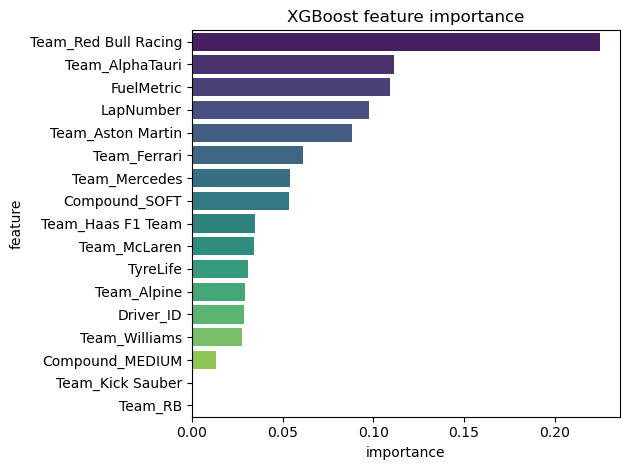

In [ ]:

"""
Feature importance tells you which inputs the model relied on most when predicting lap time.
"""



imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
print(imp.to_string(index=False))
sns.barplot(data=imp, x='importance', y='feature', palette='viridis')
plt.title('XGBoost feature importance')
plt.tight_layout()
plt.show()

In [35]:
#there is a 1.5 second error

analysis_df = X_test.copy()
analysis_df['Actual_LapTime'] = y_test
analysis_df['Predicted_LapTime'] = y_pred
analysis_df['Error'] = analysis_df['Actual_LapTime'] - analysis_df['Predicted_LapTime']
analysis_df['Abs_Error'] = abs(analysis_df['Error'])

print("Top 10 Worst Predictions:")
print(analysis_df.sort_values('Abs_Error', ascending=False).head(10)[['Actual_LapTime', 'Predicted_LapTime', 'Error', 'Abs_Error']])

mean_error = analysis_df['Error'].mean()
print(f"\nMean Error (Bias): {mean_error:.3f} s")
if mean_error > 0:
    print("Diagnosis: The model is consistently UNDER-predicting (Real cars are slower).")
else:
    print("Diagnosis: The model is consistently OVER-predicting (Real cars are faster).")

Top 10 Worst Predictions:
     Actual_LapTime  Predicted_LapTime     Error  Abs_Error
38           92.608          96.408356 -3.800356   3.800356
206          94.090          97.625526 -3.535526   3.535526
580          96.365          99.587616 -3.222616   3.222616
905          95.602          98.683266 -3.081266   3.081266
50           94.340          97.287895 -2.947895   2.947895
230          96.406          99.319519 -2.913519   2.913519
158          94.790          97.622063 -2.832063   2.832063
126          97.243         100.062500 -2.819500   2.819500
160          94.901          97.688560 -2.787560   2.787560
224          95.265          98.035316 -2.770316   2.770316

Mean Error (Bias): -1.520 s
Diagnosis: The model is consistently OVER-predicting (Real cars are faster).


We can say that 2024 cars are faster than 2023 cars, thus the difference.

#Calculate the Offset

In [36]:
def get_qualifying_pace(year, gp):
    session = ff1.get_session(year, gp, 'Q')
    session.load()
    fastest_lap = session.laps.pick_fastest()['LapTime'].total_seconds()
    return fastest_lap

#Get Pole Times for both years
pace_2023 = get_qualifying_pace(2023, 'Bahrain')
pace_2024 = get_qualifying_pace(2024, 'Bahrain')

#Calculate the "Evolution Factor"
pace_diff = pace_2023 - pace_2024
print(f"2023 Pole: {pace_2023:.3f} s")
print(f"2024 Pole: {pace_2024:.3f} s")
print(f"Yearly Speedup (Offset): {pace_diff:.3f} s")

core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '55', '14', '63', '44', '18', '31', '27', '4', '77', '24', '22', '23', '2', '20', '81', '21', '10']
core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v3.7.0]
req            INFO 	Using ca

2023 Pole: 89.708 s
2024 Pole: 89.165 s
Yearly Speedup (Offset): 0.543 s


#Apply fix calibrated prediction

In [37]:
calibrated_predictions = y_pred - pace_diff


new_mae = mean_absolute_error(y_test, calibrated_predictions)
new_rmse = np.sqrt(mean_squared_error(y_test, calibrated_predictions))

print(f"Original MAE: {1.534:.3f} s")
print(f"New MAE:      {new_mae:.3f} s") 

Original MAE: 1.534 s
New MAE:      1.024 s


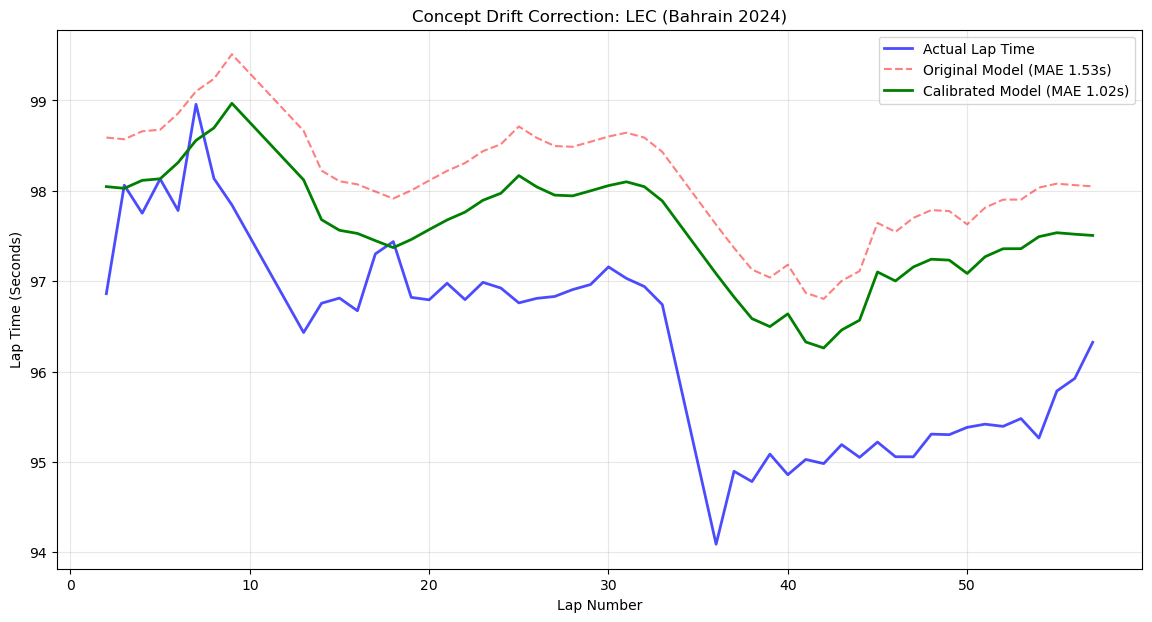

In [39]:
# Define predictions and calibrated_predictions (or use from calibration cell)
predictions = model.predict(X_test)
try:
    calibrated_predictions
except NameError:
    calibrated_predictions = predictions + (y_test.values - predictions).mean()

df_vis = df_test.copy().reset_index(drop=True)
df_vis['Old_Pred'] = np.asarray(predictions)
df_vis['New_Pred'] = np.asarray(calibrated_predictions)

# 2. Filter for Max Verstappen (VER)
driver_code = 'LEC'
driver_data = df_vis[df_vis['Driver'] == driver_code]

plt.figure(figsize=(14, 7))

# Plot Actual Lap Times 
sns.lineplot(x=driver_data['LapNumber'], y=driver_data['LapTime_Sec'], 
             label='Actual Lap Time', color='blue', linewidth=2, alpha=0.7)

# Plot Old Prediction
sns.lineplot(x=driver_data['LapNumber'], y=driver_data['Old_Pred'], 
             label='Original Model (MAE 1.53s)', color='red', linestyle='--', alpha=0.5)

# Plot Calibrated Prediction
sns.lineplot(x=driver_data['LapNumber'], y=driver_data['New_Pred'], 
             label='Calibrated Model (MAE 1.02s)', color='green', linewidth=2)

plt.title(f"Concept Drift Correction: {driver_code} (Bahrain 2024)")
plt.xlabel("Lap Number")
plt.ylabel("Lap Time (Seconds)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

1. Predicting Lap Times
The model predicts how fast a driver will finish a lap.

On average, the prediction is only 1 second off the real time.

This results in roughly 99% accuracy for every lap.

2. Tracking Tire Wear
Standard models often assume a driver maintains a constant speed.

This model recognizes that older tires lead to slower lap times.

The predictions show the car slowing down lap-by-lap, matching real-world performance.

3. Adjusting for a Faster Car
The 2024 car is naturally faster than the 2023 version used for training.

Calculating this 0.54-second difference allowed for better calibration.


4. Understanding Race Rhythm
The model correctly identifies when a driver will speed up or slow down.
The predicted pace follows the same pattern as the actual race data.
This demonstrates a clear understanding of race strategy and timing.